### Edgar Moises Hernandez-Gonzalez
#### 22/07/20-23/07/20
#### Clasificacion de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Entrada resize proporcional de 67x500
##### 5 ejecuciones independientes

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pywt
import cv2
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/MI-EEG-B9E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_train_9.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2b/Datos/etiquetas_test_9.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 3000)
(320, 3000)
(400, 1)
(320, 1)


In [7]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 400
n_samples_test : 320


In [8]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [9]:
#unir 3 canales
def unir_escalogramas_vertical(data):
  dim = (500, 67) #ancho, alto
  fs = 250
  escalas = pywt.scale2frequency('cmor3-3', np.arange(8,30.5,0.5)) / (1/fs)
  datos = np.zeros((data.shape[0],67,500))
  temporal = np.zeros((135,1000))
  for i in range(data.shape[0]): #n muestras
    for j in range(3): #3 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      # escalograma CWT
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3', sampling_period = (1 / fs))
      temporal[j*45:(j+1)*45, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [10]:
#llamar a unir_escalogramas_vertical(data)
inicio = time.time()

x_train = unir_escalogramas_vertical(x_train)
x_test = unir_escalogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
200
300
0
100
200
300
Tiempo: 43.05738043785095


In [11]:
print(x_train.shape)
print(x_test.shape)

(400, 67, 500)
(320, 67, 500)


In [12]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

14.436868751355295
10.02190375711196
0.008739063517846717
0.014337447367408683
0.9064047023882846
0.8216961871534796


In [13]:
x = np.ceil(np.max(x_train))

In [14]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9624579
0.66812694
0.00058260426
0.0009558298
0.060426984
0.054779753


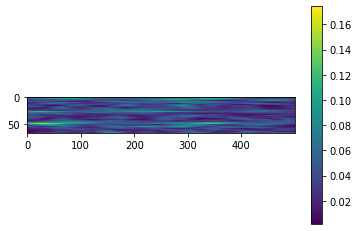

In [16]:
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.show()

In [17]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(400, 67, 500, 1)
(320, 67, 500, 1)


In [18]:
mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2b/Modelos/CWT_CNN_09.hdf5',
                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [19]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(8, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.4083339810371399
accuracy:  0.8062499761581421
kappa:  0.6125
confusion matrix:
 [[147  13]
 [ 49 111]]


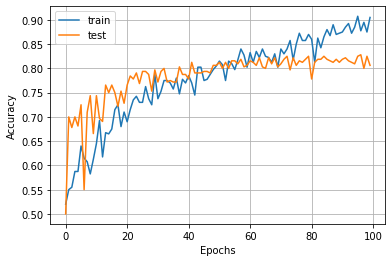

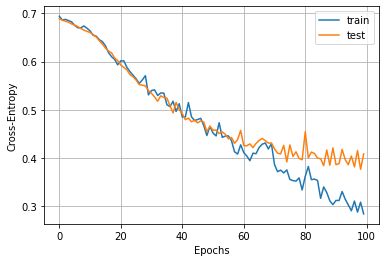

Iteration: 2
loss:  0.4594919592142105
accuracy:  0.768750011920929
kappa:  0.5375
confusion matrix:
 [[153   7]
 [ 67  93]]


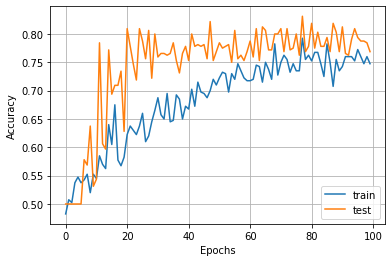

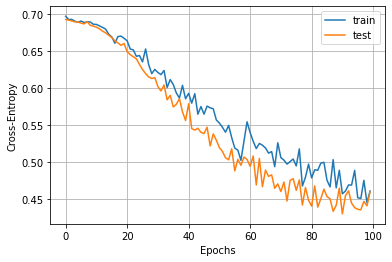

Iteration: 3
loss:  0.4611905336380005
accuracy:  0.8031250238418579
kappa:  0.60625
confusion matrix:
 [[138  22]
 [ 41 119]]


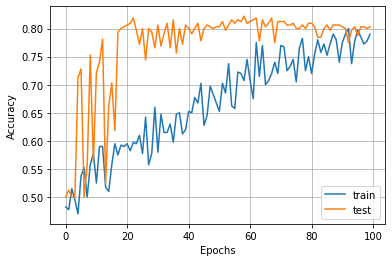

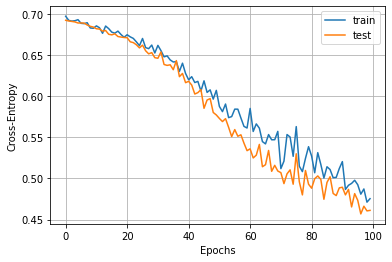

Iteration: 4
loss:  0.3940307557582855
accuracy:  0.8125
kappa:  0.625
confusion matrix:
 [[147  13]
 [ 47 113]]


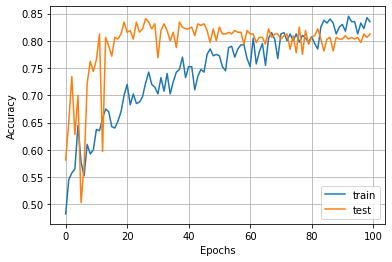

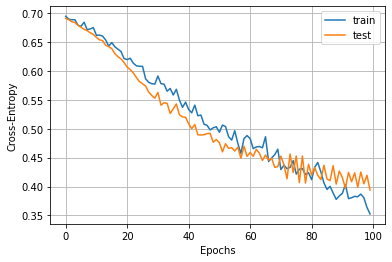

Iteration: 5
loss:  0.41180779188871386
accuracy:  0.784375011920929
kappa:  0.56875
confusion matrix:
 [[145  15]
 [ 54 106]]


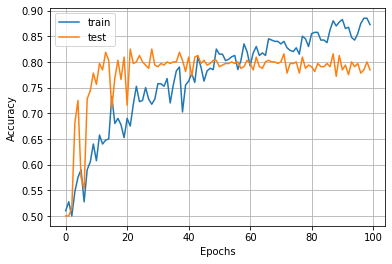

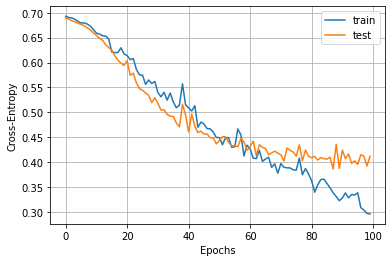


Resultados:
loss: [0.4083339810371399, 0.4594919592142105, 0.4611905336380005, 0.3940307557582855, 0.41180779188871386]
accuracy: [0.8062499761581421, 0.768750011920929, 0.8031250238418579, 0.8125, 0.784375011920929]
kappa: [0.6125, 0.5375, 0.60625, 0.625, 0.56875]
Tiempo: 171.08401727676392


In [20]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  history = model.fit(x_train, y_train, epochs=100, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0,
                      callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 67, 500, 8)        80        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 33, 250, 8)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 33, 250, 8)        584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 125, 8)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                256016    
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)               

In [22]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.7950
std: (+/- 0.0161)
Mean Kappa: 0.5900
std: (+/- 0.0323)
Max Accuracy: 0.8125
Max Kappa: 0.6250
Tiempo: 171


In [23]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul 23 17:01:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    89W / 149W |   1271MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------